# Copyright
DACON Competition, “코로나 데이터 시각화 AI 경진대회(Data Visualization AI Competition) Sponsored by DS4C and Monthly DACON in April 2020” [Online]. Available at:https://dacon.io/competitions/official/235590/codeshare/949 [Accessed 6 January 2020]

***Winner Team(VisualisingKorea) Summary Report: https://visualisingkorea.com/2020/07/13/visualisingkorea-wins-data-science-competition-on-covid-19/***

***Code modified by Chaeyoon Kim(Chaeyoon.Kim@city.ac.uk)***

In [1]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings  
warnings.filterwarnings('ignore')

# 1. Pre-processing

In [2]:
patient = pd.read_csv('PatientInfo.csv')
patient.head(3)

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31.00,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17.00,NaN,2020-01-30,2020-02-19,NaN,released


In [3]:
print(patient.shape, len(patient.patient_id.unique()))  

(5165, 14) 5164


In [4]:
data = patient.copy()

## 1.1. 감염 경로 유형 (Infection route)

In [5]:
print('the number of unique values in infection_case:',len(data['infection_case'].unique())) 
data['infection_case'].unique()

the number of unique values in infection_case: 52


array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', nan, 'Itaewon Clubs',
       'Samsung Medical Center', 'Biblical Language study meeting',
       'Coupang Logistics Center', 'Guri Collective Infection',
       'KB Life Insurance', 'Gangnam Dongin Church',
       'Korea Campus Crusade of Christ',
       'Yeongdeungpo Learning Institute', 'Yeonana News Class',
       'SMR Newly Planted Churches Group', 'Seocho Family',
       'Anyang Gunpo Pastors Group', 'Richway',
       'Samsung Fire & Marine Insurance', 'Yangcheon Table Tennis Club',
       'Yongin Brothers', 'Day Care Center',
       'Geumcheon-gu rice milling machine manufacture', 'Daezayeon Korea',
       'Orange Life', 'Daejeon door-to-door sales',
       'Seoul City Hall Station safety worker', 'Uiwang Logistics Center',
       'Wangsung Church', 'Gangnam Yeoksam-dong gathering',
       'Onchun

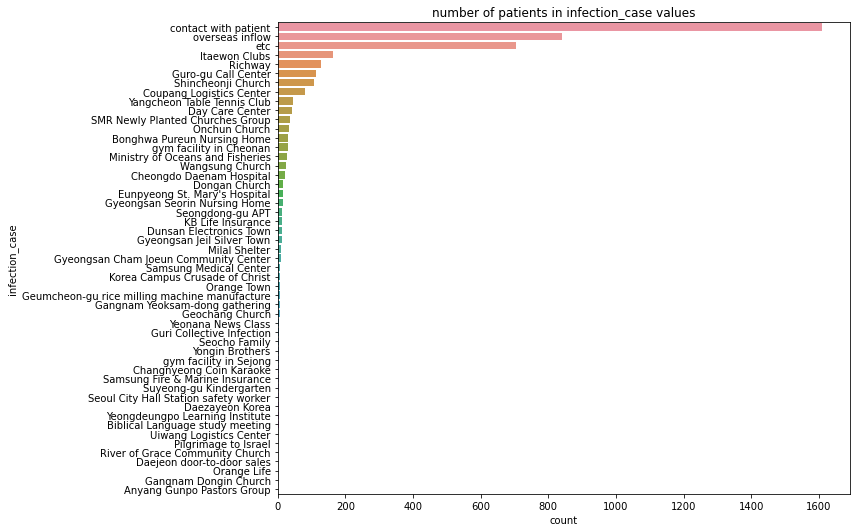

In [6]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

g = g.sort_values('count', ascending = False)

plt.figure(figsize = (12,7.5))
plt.title('number of patients in infection_case values')
sns.barplot(y = 'infection_case', x= 'count', data = g)
plt.tight_layout()
plt.show()

In [7]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = pd.DataFrame(g)

infection_case_less_than_5 = g[g['patient_id'] < 5].index.tolist()
g[g.index.isin(infection_case_less_than_5)]

,patient_id
infection_case,
Anyang Gunpo Pastors Group,1
Biblical Language study meeting,3
Changnyeong Coin Karaoke,4
Daejeon door-to-door sales,1
Daezayeon Korea,3
Gangnam Dongin Church,1
Orange Life,1
Pilgrimage to Israel,2
River of Grace Community Church,1


In [8]:
print('original data shape:', data.shape)
data = data[~(data['infection_case'].isin(infection_case_less_than_5))]
print('data shape after slicing: ', data.shape)

original data shape: (5165, 14)
data shape after slicing:  (5125, 14)


In [9]:
data[data['infection_case'].isna()].shape

(919, 14)

In [10]:
def categorisation(x):
    
    '''
    categorises infection types
    '''
    
    if x == 'overseas inflow':
        y = 'overseas'
    elif x == 'contact with patient': 
        y = 'individual'
    elif (x == 'etc') | (pd.isna(x)):
        y = 'unknown'
    else: 
        y = 'group' 
    
    return y 

data['infection'] = data['infection_case'].apply(lambda x: categorisation(x))
print(data.shape)
data.head()

(5125, 15)


,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual


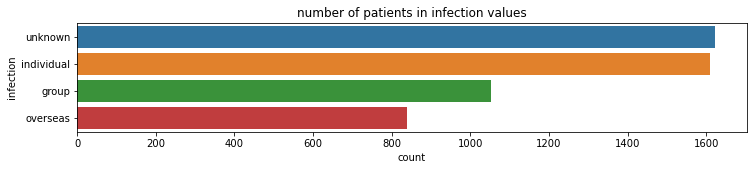

In [11]:
g = data.groupby(['infection'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

g = g.sort_values('count', ascending = False)

plt.figure(figsize = (12,2))
sns.barplot(y = 'infection', x= 'count', data = g)
plt.title('number of patients in infection values')
display()

## 1.2. 유동성 (Mobility level)

In [12]:
### Bring in PatientRoute data
route = pd.read_csv('PatientRoute.csv')
route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.00,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.62,126.72
1,1000000001,2.00,2020-01-24,Seoul,Jung-gu,hospital,37.57,127.01
2,1000000002,5.00,2020-01-25,Seoul,Seongbuk-gu,etc,37.59,127.02
3,1000000002,5.00,2020-01-26,Seoul,Seongbuk-gu,store,37.59,127.02
4,1000000002,5.00,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56,127.03


In [13]:
print('the number of unique values in type:', len(route['type'].unique()))
route['type'].unique()

the number of unique values in type: 25


array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'academy', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'park', 'lodging', 'university', 'administrative_area_level_1'],
      dtype=object)

In [14]:
route[route['type'].isna()].shape

(0, 8)

In [15]:
## categories
leisure = ['restaurant', 'beauty_salon', 'pc_cafe', 'cafe', 'bakery', 'bar',
          'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'park']
essential_admin = ['administrative_area_level_1']
non_essential_admin = ['bank', 'real_estate_agency', 'post_office']
necessity = ['store', 'public_transportation', 'gas_station' ]
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

In [16]:
essential = essential_edu + essential_admin + necessity + medical 

def type_group_essen(x): 
     
    group = None
    if x in essential: 
        group = 'essential'
    else:
        group = 'non-essential' 
    return group 

route['route_group_essential'] = route['type'].apply(lambda x: type_group_essen(x)) 
route = route[['patient_id', 'type', 'route_group_essential']]
route.head()

,patient_id,type,route_group_essential
0,1000000001,airport,non-essential
1,1000000001,hospital,essential
2,1000000002,etc,non-essential
3,1000000002,store,essential
4,1000000002,public_transportation,essential


In [17]:
route['route_value'] = 1
g = pd.DataFrame(route.groupby(['patient_id', 'route_group_essential'])['route_value'].count().unstack())
g

route_group_essential,essential,non-essential
patient_id,,
1000000001,1.00,1.00
1000000002,9.00,4.00
1000000003,NaN,2.00
1000000004,1.00,NaN
1000000005,1.00,NaN
...,...,...
6100000086,2.00,2.00
6100000087,6.00,2.00
6100000088,5.00,19.00


In [18]:
g.fillna(0, inplace = True)
g.reset_index(inplace = True)
g = g[['patient_id', 'essential', 'non-essential']]
g.head()

route_group_essential,patient_id,essential,non-essential
0,1000000001,1.00,1.00
1,1000000002,9.00,4.00
2,1000000003,0.00,2.00
3,1000000004,1.00,0.00
4,1000000005,1.00,0.00


In [19]:
data = data.merge(g, left_on = 'patient_id', right_on = 'patient_id', how = 'left')
data.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas,9.00,4.00
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual,0.00,2.00
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual,1.00,0.00


In [20]:
data.to_csv('file_name.csv', encoding='utf-8')

In [21]:
print(data.shape)
data[(data['essential'].isna()) | (data['non-essential'].isna())].shape

(5125, 17)


(3667, 17)

In [22]:
print('original data shape:', data.shape)
data = data[(data['essential'].notna()) & (data['non-essential'].notna())] 
print('data shape after removing missing values in essentail/non-essential:', data.shape)

original data shape: (5125, 17)
data shape after removing missing values in essentail/non-essential: (1458, 17)


## 1.3. 접촉 정도 (Number of contacts)

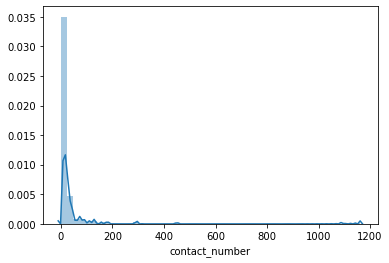

In [23]:
sns.distplot(data['contact_number'])
display()

In [24]:
data['contact_number'].describe()

count    362.00
mean      23.46
std       91.58
min        0.00
25%        2.00
50%        5.00
75%       17.00
max     1160.00
Name: contact_number, dtype: float64

In [25]:
data[data['contact_number'] > 1000]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
1286,1100000001,male,10s,Korea,Busan,Dongnae-gu,Onchun Church,NaN,1091.00,NaN,2020-02-21,NaN,NaN,released,group,8.00,8.00
1434,1200000031,female,60s,Korea,Daegu,NaN,Shincheonji Church,NaN,1160.00,NaN,2020-02-18,NaN,NaN,isolated,group,11.00,5.00


In [26]:
print('original data shape:', data.shape)
data = data[data['contact_number'].notna()]
print('data shape after removing missing values in contact_number:', data.shape)

original data shape: (1458, 17)
data shape after removing missing values in contact_number: (362, 17)


## 1.4. 확진받기까지 걸린 시간 (Diagnosis time)

In [27]:
print('data shape:', data.shape)
print('missing values in symptom_onset_date:', data[data['symptom_onset_date'].isna()].shape)
print('missing values in confirmed_date:', data[data['confirmed_date'].isna()].shape)

data shape: (362, 17)
missing values in symptom_onset_date: (229, 17)
missing values in confirmed_date: (0, 17)


In [28]:
### Cleaning symptom onset date
data[data['symptom_onset_date'] == ' ']
data['symptom_onset_date'] = np.where((data['symptom_onset_date'] == ' '), None, data['symptom_onset_date'])

### Remove missing values in symptom_onset_date
print('original data shape: ', data.shape)
data = data[data['symptom_onset_date'].notna()]
print('data excluding missing values in symptom_onset_date: ', data.shape)

original data shape:  (362, 17)
data excluding missing values in symptom_onset_date:  (133, 17)


In [29]:
### Define time that lapsed between the onset of COVID-19 symptoms and the official COVID-19 diagnosis

## Convert str into date func.
def convert_date(x):
    x = pd.datetime.strptime(x, '%Y-%m-%d').date()
    return x

In [30]:
## convert symptom_onset_date/confirmed_date into date format
data['symptom_onset_date'] = data['symptom_onset_date'].apply(lambda x : convert_date(x))
data['confirmed_date'] = data['confirmed_date'].apply(lambda x: convert_date(x))

data.head(3)

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
13,1000000014,female,60s,Korea,Seoul,Jongno-gu,contact with patient,1000000013,27.00,2020-02-06,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00


In [31]:
## find time lapsed between symptom_onset_date and confirmed_date
data['days_notice'] = data['confirmed_date'] - data['symptom_onset_date'] 
data['hours_notice'] = data['days_notice'].apply(lambda x: round(x.total_seconds()/3600, 2))
data['days'] = data['hours_notice'].apply(lambda x: int(x/24))
data.head(3)

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential,days_notice,hours_notice,days
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00,1 days,24.00,1
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00,4 days,96.00,4
13,1000000014,female,60s,Korea,Seoul,Jongno-gu,contact with patient,1000000013,27.00,2020-02-06,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00,10 days,240.00,10


# 2. Building cluster model

In [32]:
data_ = data[['patient_id', 
              'days', 
              'contact_number', 
              'essential', 'non-essential', 
              'infection']]
data_.reset_index(drop = True, inplace = True)
print(data_.shape)
data_.head()

(133, 6)


,patient_id,days,contact_number,essential,non-essential,infection
0,1000000001,1,75.00,1.00,1.00,overseas
1,1000000004,4,9.00,1.00,0.00,overseas
2,1000000014,10,27.00,10.00,3.00,individual
3,1000000015,8,8.00,6.00,3.00,group
4,1000000302,1,8.00,1.00,0.00,overseas


In [33]:
encoder = OneHotEncoder(categories = 'auto', sparse=False)
encoder.fit(np.array(data_['infection']).reshape(-1, 1))
inf_dummies = encoder.transform(np.array(data_['infection']).reshape(-1, 1))
dummies = pd.DataFrame(inf_dummies.astype(int), columns = ['infection_' + x for x in encoder.categories_[0]])

data_ = data_.join(dummies)
print(data_.shape)
data_.head()

(133, 10)


,patient_id,days,contact_number,essential,non-essential,infection,infection_group,infection_individual,infection_overseas,infection_unknown
0,1000000001,1,75.00,1.00,1.00,overseas,0,0,1,0
1,1000000004,4,9.00,1.00,0.00,overseas,0,0,1,0
2,1000000014,10,27.00,10.00,3.00,individual,0,1,0,0
3,1000000015,8,8.00,6.00,3.00,group,1,0,0,0
4,1000000302,1,8.00,1.00,0.00,overseas,0,0,1,0


In [34]:
inputs = ['days', 
          'essential', 'non-essential', 'contact_number',
          'infection_group', 'infection_individual', 'infection_overseas', 'infection_unknown']

X = data_[inputs]
print(X.shape)
X.head()

(133, 8)


,days,essential,non-essential,contact_number,infection_group,infection_individual,infection_overseas,infection_unknown
0,1,1.00,1.00,75.00,0,0,1,0
1,4,1.00,0.00,9.00,0,0,1,0
2,10,10.00,3.00,27.00,0,1,0,0
3,8,6.00,3.00,8.00,1,0,0,0
4,1,1.00,0.00,8.00,0,0,1,0


In [35]:
X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)  

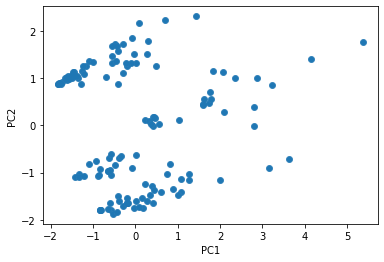

In [36]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

ax = sns.scatterplot(x='PC1', y='PC2', data = principalDF) 
sns.regplot(x=principalDF['PC1'], y=principalDF['PC2'], fit_reg=False)

display()

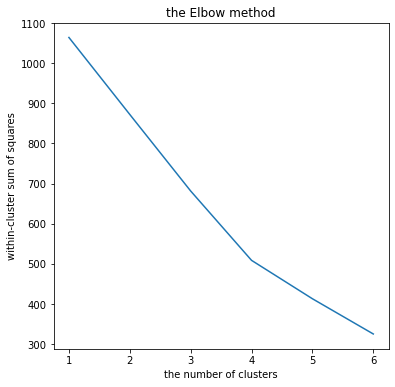

In [37]:
cluster_range = range(1,7)
cluster_errors = []
for n in cluster_range:
    cluster = KMeans(n)
    cluster.fit(X)
    cluster_errors.append(cluster.inertia_)

plt.figure(figsize = (6,6))
plt.plot(cluster_range, cluster_errors)
plt.title('the Elbow method')
plt.xlabel('the number of clusters')
plt.ylabel('within-cluster sum of squares')
display()

In [38]:
km = KMeans(n_clusters = 5)
km.fit(X)

centroids = km.cluster_centers_ 
labels= km.labels_
data_['label'] = labels

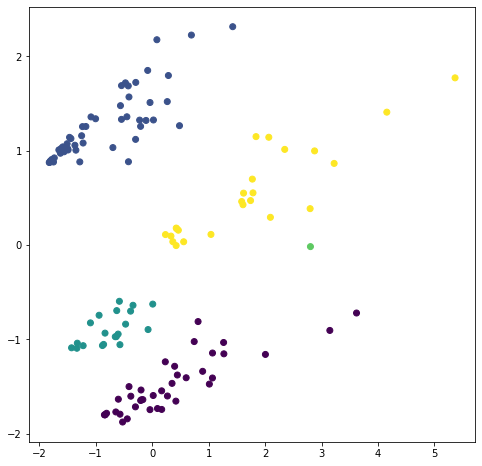

In [39]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

plt.figure(figsize = (8,8))
plt.scatter('PC1', 'PC2', data = principalDF, c = labels)

display()

In [40]:
data_.groupby(['label'])['patient_id'].count()

label
0    39
1    49
2    20
3     1
4    24
Name: patient_id, dtype: int64

In [41]:
data_[data_['label'] == 4]

,patient_id,days,contact_number,essential,non-essential,infection,infection_group,infection_individual,infection_overseas,infection_unknown,label
6,1100000003,1,16.00,1.00,2.00,unknown,0,0,0,1,4
17,1100000050,6,11.00,9.00,2.00,unknown,0,0,0,1,4
18,1100000053,6,30.00,8.00,9.00,unknown,0,0,0,1,4
22,1100000059,5,71.00,8.00,3.00,unknown,0,0,0,1,4
26,1100000066,6,5.00,4.00,6.00,unknown,0,0,0,1,4
27,1100000069,7,0.00,14.00,21.00,unknown,0,0,0,1,4
28,1100000071,0,1.00,2.00,0.00,unknown,0,0,0,1,4
29,1100000073,5,1.00,3.00,12.00,unknown,0,0,0,1,4
30,1100000075,2,38.00,4.00,15.00,unknown,0,0,0,1,4
32,1100000078,8,13.00,11.00,15.00,unknown,0,0,0,1,4


In [42]:
data_ = data_[data_['patient_id'] != 1300000001]
data_.reset_index(drop = True, inplace = True)

X = data_[inputs]
print('X shape:', X.shape) 

X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

km = KMeans(n_clusters = 4)
km.fit(X)

centroids = km.cluster_centers_ 
labels= km.labels_
data_['label'] = labels

X shape: (132, 8)


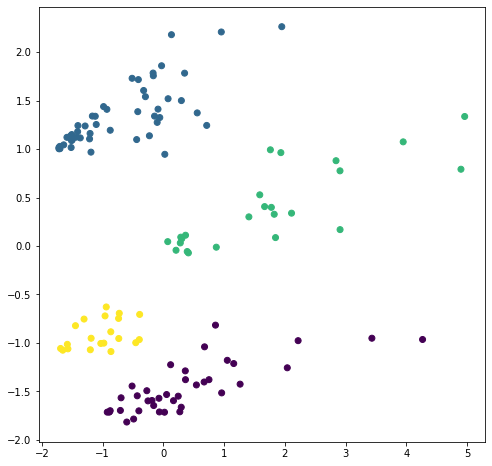

In [43]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

plt.figure(figsize = (8,8))
plt.scatter('PC1', 'PC2', data = principalDF, c = labels)

display()

# 3. Cluster 분석 결과: 코로나19 확진자들의 네 가지 유형

# 4. 코로나19 확진이 늦어지면 사망 위험도 높아질까?

In [44]:
p = pd.read_csv('PatientInfo.csv')
p = p[p['state'] != 'isolated']
p['symptom_onset_date'] = np.where(p['symptom_onset_date'] == ' ', np.nan, p['symptom_onset_date'])
p = p[(p['symptom_onset_date'].notna()) & p['confirmed_date'].notna()]
print('number of patients to be plotted:', p.shape)

number of patients to be plotted: (410, 14)


In [45]:
### Define time that lapsed between the onset of COVID-19 symptoms and the official COVID-19 diagnosis

def convert_date(x):
    '''
    The function converts string into pandas date format
    '''
    x = pd.datetime.strptime(x, '%Y-%m-%d').date()
    return x

p['symptom_onset_date'] = p['symptom_onset_date'].apply(lambda x : convert_date(x))
p['confirmed_date'] = p['confirmed_date'].apply(lambda x: convert_date(x))
p['days_notice'] = p['confirmed_date'] - p['symptom_onset_date'] 
p['hours_notice'] = p['days_notice'].apply(lambda x: round(x.total_seconds()/3600, 2))
p['days'] = p['hours_notice'].apply(lambda x: int(x/24))

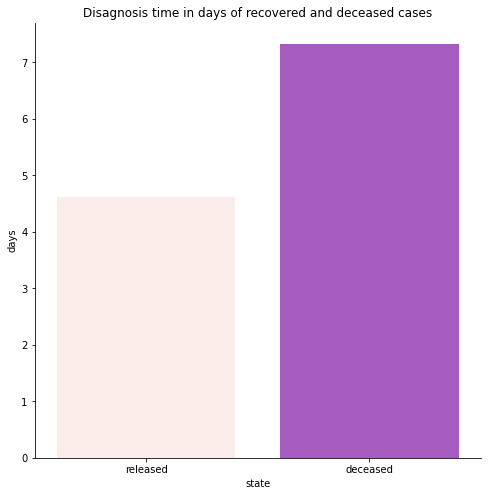

In [46]:
g = p.groupby(['state']).mean()['days']
g = pd.DataFrame(g)

plt.figure(figsize= (8,8))

ax =sns.barplot(g.index, g['days'], order = ['released', 'deceased'],
            palette = {'released': '#FCEAE6', 'deceased': '#AF4BCE'})

ax.set_title('Disagnosis time in days of recovered and deceased cases')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

display()

In [47]:
def draw_chart(date): 
    
    df = p.copy()
    df = df[df['confirmed_date'] <= date] 
    df = df[df['state'] != 'isolated']  

    g = df.groupby(['state']).mean()['days']
    g = pd.DataFrame(g)
    
    sns.barplot(g.index, g['days'], order = ['released', 'deceased'],
            palette = {'released': '#FCEAE6', 'deceased': '#AF4BCE'}, ax = ax)    
    
    label.set_text(date)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.xlabel('State')
    plt.ylabel('Diagnosis time')

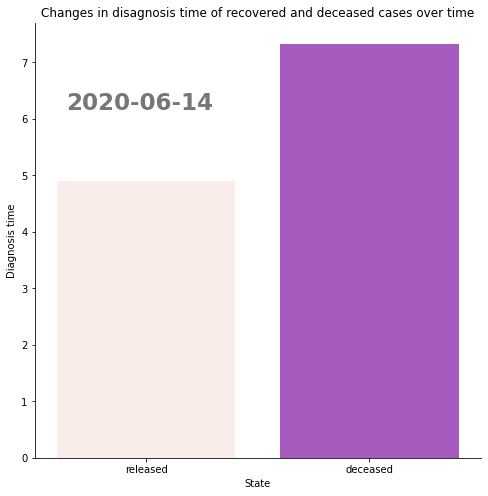

In [48]:
fig, ax = plt.subplots(figsize=(8, 8)) 

year = np.sort(p['confirmed_date'].unique())
label = ax.text(0.07, 0.8, year[0], transform = ax.transAxes, 
            color='#777777', size = 23, horizontalalignment='left', weight=800)

ax.set_title('Changes in disagnosis time of recovered and deceased cases over time')

animator = animation.FuncAnimation(fig, draw_chart, frames = year)
HTML(animator.to_jshtml())